#Image Classification with Autoencoder
In this task, we wish to classify "quickdraw_bitmap" dataset via SVM, however, a high dimension input vector may decrease the performance of SVM. Therefore, you are ask to build an autoencoder to compress the features (input).</br>
For the full task, you are ask to do: </br>
1. build and train an autoencoder. (30%)
2. use the features from your autoencoder to classify quickdraw_bitmap dataset via SVM. (15%)
3. use the features from your autoencoder to classify quickdraw_bitmap dataset via KNN. (15%)
4. Make a discussion between SVM and KNN's result. (20%)
加分題. compare the result with CNN model. (20%)

more information about "[quickdraw_bitmap](https://github.com/googlecreativelab/quickdraw-dataset)" dataset
![](https://i.imgur.com/19sDCHv.png)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout ,BatchNormalization, GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical ## used to one-hot your label
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import urllib.request

### 1. Build and train an autoencoder

Since sending the whole image vector to SVM is not a good idea (too many dimensions), a autoencoder is a model used to reduce the number of your input features.</br>
<center>Fig1. concept of a autoencoder</center>

<p align="center">
<img src="https://i.imgur.com/pESsHbt.png">
</p></br>

* **Note that when you are training a autoencoder, your label is the image itself!**
* **You should resize your image if you use a dense layer autoencoder.**
* **Use 'mse' as your loss function, the key is how complete your network reconstruct your image so loss value is what really matters**

In [ ]:
## you don't have to change this cell's code, it is used to generate pre-setting data for you.
classes = ['brain', 'snake', 'zebra', 'nose', 'snowman'] # with respect to label 0 to 4

for c in classes:
    if not os.path.exists('/content/' + c + '.npy'):
        with open('/content/' + c + '.npy', 'w'): pass

def download(testSplit = 0.2, maxItemPerClass = 5000):
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    x = np.empty([1, 28, 28])
    y = np.empty([0])
    labelCounter = 0

    for c in classes:
        cls_url = c.replace('_', '%20')
        path = base+cls_url+'.npy'
        print(path)
        urllib.request.urlretrieve(path, '/content/'+c+'.npy')
        load_url = '/content/'+c+'.npy'
        data = np.load(load_url)
        data = data[0: maxItemPerClass, :].reshape(-1, 28, 28)
        labels = np.full(data.shape[0], labelCounter)
        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)
        labelCounter += 1
    x = x[1:, :, :]

    (quickdrawTrainImage, quickdrawTestImage, quickdrawTrainLabel, quickdrawTestLabel) = train_test_split(x, y, test_size = testSplit, random_state = 42)

    return quickdrawTrainImage, quickdrawTestImage, quickdrawTrainLabel, quickdrawTestLabel

## the label you get here is already in one-hot form
quickdrawTrainImage, quickdrawTestImage, quickdrawTrainLabel, quickdrawTestLabel = download(testSplit = 0.2, maxItemPerClass = 5000)

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/brain.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/snake.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/zebra.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/nose.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/snowman.npy


quickdrawTrainImage:  (20000, 28, 28)
quickdrawTrainLabel:  (20000,)
quickdrawTestImage:  (5000, 28, 28)
quickdrawTestLabel:  (5000,)


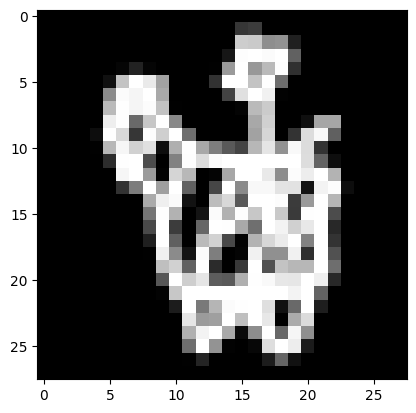

In [ ]:
plt.imshow(quickdrawTrainImage[1061, :, :], cmap = 'gray')
print('quickdrawTrainImage: ', quickdrawTrainImage.shape)
print('quickdrawTrainLabel: ', quickdrawTrainLabel.shape)
print('quickdrawTestImage: ', quickdrawTestImage.shape)
print('quickdrawTestLabel: ', quickdrawTestLabel.shape)

In [ ]:
# pre-processing of your data if needed
"""Fill your code"""
quickdrawTrainImage = np.reshape(quickdrawTrainImage, (-1,784))
quickdrawTestImage = np.reshape(quickdrawTestImage, (-1,784))
quickdrawTrainImage = quickdrawTrainImage / 255
quickdrawTestImage = quickdrawTestImage / 255
quickdrawTrainImage.shape, quickdrawTestImage.shape

((20000, 784), (5000, 784))

In [ ]:
# Build an autoencoder model here, modify if needed.
# Aware that you will need to use the output of the encoder in the next task.

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

input = Input(shape=(784,))
encoded = Dense(32)(input)
decoded = Dense(784)(encoded)

autodecoder = Model(inputs = input, outputs= decoded)
autodecoder.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_26 (Dense)            (None, 32)                25120     
                                                                 
 dense_27 (Dense)            (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autodecoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
          loss='mse')
history = autodecoder.fit(x = quickdrawTrainImage, y = quickdrawTrainImage, epochs = 20,
              validation_split=0.2, callbacks=[callback,model_checkpoint_callback])

Epoch 1/20
480/500 [===========================>..] - ETA: 0s - loss: 0.0597

500/500 [==============================] - 2s 3ms/step - loss: 0.0591 - val_loss: 0.0455
Epoch 2/20
492/500 [============================>.] - ETA: 0s - loss: 0.0433

500/500 [==============================] - 1s 3ms/step - loss: 0.0433 - val_loss: 0.0424
Epoch 3/20
490/500 [============================>.] - ETA: 0s - loss: 0.0419

500/500 [==============================] - 1s 3ms/step - loss: 0.0419 - val_loss: 0.0419
Epoch 4/20
491/500 [============================>.] - ETA: 0s - loss: 0.0417

500/500 [==============================] - 1s 3ms/step - loss: 0.0417 - val_loss: 0.0417
Epoch 5/20
481/500 [===========================>..] - ETA: 0s - loss: 0.0415

500/500 [==============================] - 1s 3ms/step - loss: 0.0415 - val_loss: 0.0416
Epoch 6/20
485/500 [============================>.] - ETA: 0s - loss: 0.0415

500/500 [==============================] - 1s 3ms/step - loss: 0.0415 - val_loss: 0.0415
Epoch 7/20
490/500 [============================>.] - ETA: 0s - loss: 0.0414

500/500 [==============================] - 2s 3ms/step - loss: 0.0414 - val_loss: 0.0415
Epoch 8/20
499/500 [============================>.] - ETA: 0s - loss: 0.0414

500/500 [==============================] - 2s 4ms/step - loss: 0.0414 - val_loss: 0.0415
Epoch 9/20
486/500 [============================>.] - ETA: 0s - loss: 0.0414

500/500 [==============================] - 1s 3ms/step - loss: 0.0414 - val_loss: 0.0415
Epoch 10/20
498/500 [============================>.] - ETA: 0s - loss: 0.0414

500/500 [==============================] - 1s 3ms/step - loss: 0.0414 - val_loss: 0.0415
Epoch 11/20
479/500 [===========================>..] - ETA: 0s - loss: 0.0414

500/500 [==============================] - 1s 3ms/step - loss: 0.0413 - val_loss: 0.0414
Epoch 12/20
480/500 [===========================>..] - ETA: 0s - loss: 0.0413

500/500 [==============================] - 1s 3ms/step - loss: 0.0414 - val_loss: 0.0414
Epoch 13/20
494/500 [============================>.] - ETA: 0s - loss: 0.0413

500/500 [==============================] - 1s 3ms/step - loss: 0.0413 - val_loss: 0.0416
Epoch 14/20
492/500 [============================>.] - ETA: 0s - loss: 0.0413

500/500 [==============================] - 1s 3ms/step - loss: 0.0413 - val_loss: 0.0414
Epoch 15/20
499/500 [============================>.] - ETA: 0s - loss: 0.0413

500/500 [==============================] - 1s 3ms/step - loss: 0.0413 - val_loss: 0.0414
Epoch 16/20
494/500 [============================>.] - ETA: 0s - loss: 0.0413

500/500 [==============================] - 2s 3ms/step - loss: 0.0413 - val_loss: 0.0414


### 2. Use the features from your autoencoder to classify quickdraw_bitmap dataset via SVM.
Goal for test accuracy: 75% $\uparrow$

In [ ]:
# Do other image/data preprocessing here if needed.
"""Fill your code"""

In [ ]:
# Build SVM classifier model here, modify if needed.
"""Fill your code"""
encoder = Model(inputs = input, outputs = encoded)
svm = SVC()
svm.fit(encoder(quickdrawTrainImage), quickdrawTrainLabel)

SVC()

In [ ]:
testImg = encoder(quickdrawTestImage).numpy()
predictLabel = svm.predict(testImg)
print('accuracy_score = ', accuracy_score(quickdrawTestLabel, predictLabel))

accuracy_score =  0.933


### 3. Use the features from your autoencoder to classify quickdraw_bitmap dataset via  KNN.
Goal for test accuracy: 75% $\uparrow$

In [ ]:
# Do other image/data preprocessing here if needed.
"""Fill your code"""

'Fill your code'

In [ ]:
# Build KNN classifier model here, modify if needed.
"""Fill your code"""
knn = KNeighborsClassifier()
knn.fit(quickdrawTrainImage, quickdrawTrainLabel)

KNeighborsClassifier()

In [ ]:
knn_pre = knn.predict(quickdrawTestImage)
print('accuracy_score = ', accuracy_score(quickdrawTestLabel, knn_pre))

accuracy_score =  0.9


### 4. Make a discussion between SVM and KNN's result.
you can use confusion matrix to evaluate your model.

In [ ]:
# Do other preprocessing here if needed.
"""Fill your code"""
testImg = encoder(quickdrawTestImage).numpy()
svm_pre = svm.predict(testImg)
knn_pre = knn.predict(quickdrawTestImage)

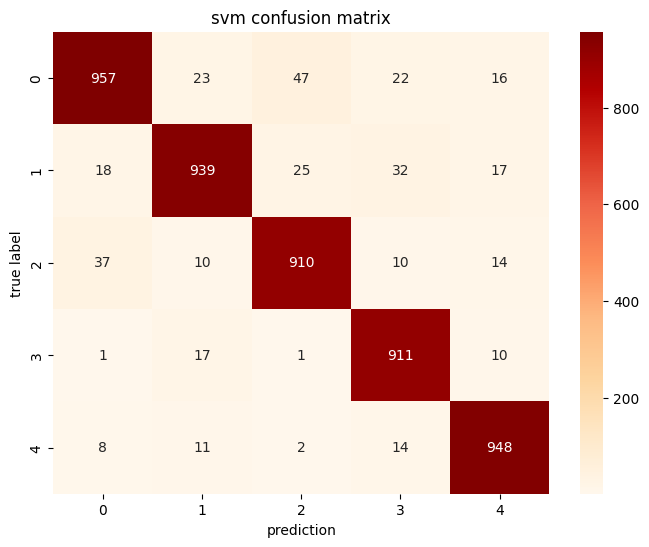

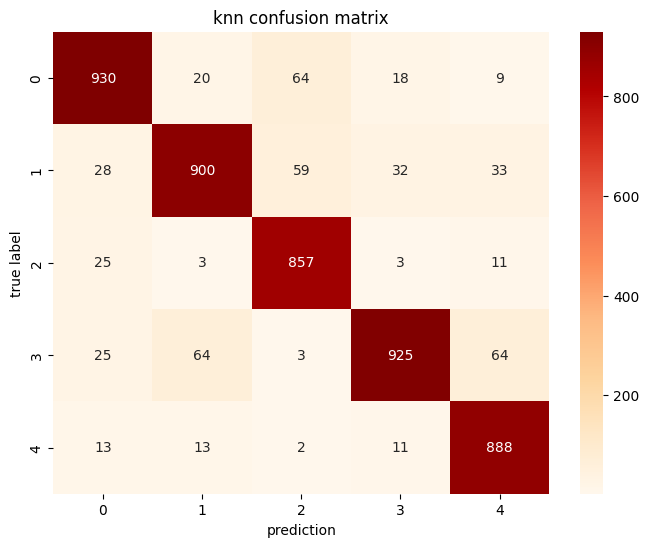

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm = confusion_matrix(svm_pre, quickdrawTestLabel)
fit=plt.figure(figsize=(8,6))
plt.title('svm confusion matrix')
sn.heatmap(cm,annot=True,cmap='OrRd',fmt='g')
plt.xlabel('prediction')
plt.ylabel('true label')
plt.show()


cm=confusion_matrix(knn_pre, quickdrawTestLabel)
fit=plt.figure(figsize=(8,6))
plt.title('knn confusion matrix')
sn.heatmap(cm,annot=True,cmap='OrRd',fmt='g')
plt.xlabel('prediction')
plt.ylabel('true label')
plt.show()